**<font size='7'>NOTEBOOK TEST</font>** 

Authors: **Massimo Romano** (2043836), **Paolo Renzi** (1887793)

This notebook tests a trained model on never before seen data, computes all the relevant metrics:

- *accuracy*: is the fraction of correctly classified instances among all the instances 

<img src="./images/Accuracy.png" alt="Description" width="200" height = "60" />

- *precision (macro)*: is the fraction of True Positive elements divided by the total number of positively **predicted** unit, averaged over each class 

<img src="./images/MacroPrecision.png" alt="Description" width="250" height = "60" />

- *recall (macro)*: is the fraction of True Positive elements divided by the total number of positively **classified** unit, averaged over each class 

<img src="./images/MacroRecall.png" alt="Description" width="250" height = "60" />

- *f1-score (macro)*: is the harmonic mean of Precision(macro) and Recall(macro) 

<img src="./images/F1score.webp" alt="Description" width="250" height = "60" />

- *loss*: cross-entropy loss of the distribution q relative to a distribution p over a given dataset 

<img src="./images/CrossEntropy.webp" alt="Description" width="200" height = "60" />

- *inference_time_one_sample*: the time it take the model to compute the logits on a single sample

- *inference_time_tot*: the sum of the time it take the model to compute the logits on all the samples

we choose the macro versions instead of the micro for precision, recall and f1-score because our classes are balanced 

saves all of them in a json file and 2 images, one for the accuracy and loss and the other for the confusion matrix.

To do so you need a dir with the weights of the model saved in a pt file, and 2 json files with the metrics saved during training

# Initialization
Change the path to the model's directory that you want to test and put the right hyper-parameters to create the right model (some are taken from the directory's name) 

In [2]:
# CHANGE THIS PART TO TEST DIFFERENT MODELS!!!
# The only parameters to change are the directory path of the model to test
# and the Activation Function type
# ****---------------------------------------****
actual_dir = "./results_tmp/CkTIM'hidden_scale': 0.1"
AF_TYPE = 'sin'
HIDDEN_SCALE = .1
N_TAB = 6
# ****---------------------------------------****
# These other are automatic based on the name of the directory!!!
# Ex. CkkTIM_aug, CkTIM (no augmentation) ...
GEN_TYPE = 'convKan' if 'Ckk' in actual_dir else 'conv'
CK = 'Ck' in actual_dir 
AUG = 'aug' in actual_dir

In [3]:
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

import dataloader.utils as utils
import dataloader.dataset as dataset
from dataloader.preprocessing import Preprocessing
from model.ctim import CTIM
from testing.test import test as test

from torch.utils.data import Dataset, DataLoader

# Check if Hydra is initialized
if GlobalHydra().is_initialized():
    # Clear the Hydra instance if it is initialized
    GlobalHydra.instance().clear()
    print("Hydra instance was initialized and has been cleared.")
else:
    # Initialize
    print("Hydra now initialized!")

# Initialization and Load configuration
initialize(config_path="./conf", job_name="notebook_nn_exam", version_base=None)
cfg = compose(config_name="config")

# Set the devide mode on GPU (if available CUDA for Nvidia and  MPS for Apple Silicon) or CPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Your device is:", device)

# Load the hyperparameters of the model
DROPOUT_RATE = cfg.model.dropout_rate
KERNEL_SIZE = cfg.model.kernel_size
N_FILTER = cfg.model.n_filter
NUM_FEATURES = cfg.model.num_features
OMEGA_0 = cfg.model.omega_0


model = CTIM(
    kernel_size=KERNEL_SIZE,
    dropout_rate=DROPOUT_RATE,
    n_temporal_aware_block=N_TAB,
    n_filter=N_FILTER,
    in_channels=39,
    ck=CK,
    generator_type= GEN_TYPE,
    num_features=NUM_FEATURES,
    num_classes = 7,
    omega_0=OMEGA_0,
    af_type=AF_TYPE,
    hidden_scale=HIDDEN_SCALE,
    device=device
)

model_path = actual_dir + '/model.pt'

Hydra now initialized!
Your device is: cuda


# Model Summary

prints a summary of the model's layers with the number of parameters for each part of the layer and a total count

In [4]:
parameters = utils.count_parameters(model)

+---------------------------------------------------------------------------------------------------+------------+
|                                              Modules                                              | Parameters |
+---------------------------------------------------------------------------------------------------+------------+
|                                      ctim_net.weightsdyn_fun                                      |     6      |
|                         ctim_net.conv_forward.kernel_gen.linear_input.bias                        |     32     |
|          ctim_net.conv_forward.kernel_gen.linear_input.parametrizations.weight.original0          |     32     |
|          ctim_net.conv_forward.kernel_gen.linear_input.parametrizations.weight.original1          |     32     |
|                        ctim_net.conv_forward.kernel_gen.linear_hidden.bias                        |     32     |
|          ctim_net.conv_forward.kernel_gen.linear_hidden.parametrizations.weigh

# TEST 

Computes all the metrics on the test set precision, recall, accuracy, f1-score and saves them in a json file,  including the inference time

In [5]:
if AUG == True:
    test_path = './dataset/EMOVO_aug/test'
    test_dataset = dataset.EMOVO_Dataset(test_path, feature_extract=True, mfcc_np=False, device=device)

    # Initialization of the dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()

    # Initialization of the test metrics dictionary
    test_metrics_dict = {
        "model" : [model.model_name],
        "epoch": [],
        "loss": [],
        "accuracy": [],
        "recall": [],
        "precision": [],
        "f1_score": [],
        "inference_time_one_sample": [],
        "inference_time_tot": [],
        "trainable_parameters": [parameters]
    }

    cm, inference_time_list = test(
        model,
        model_path,
        test_dataloader,
        test_metrics_dict,
        loss_fn
    )

elif AUG == False:

    test_path = './dataset/EMOVO_split_MFCC/test'
    test_dataset = dataset.EMOVO_Dataset(test_path, feature_extract=False, mfcc_np=True, device=device)

    # Initialization of the dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()

    # Initialization of the test metrics dictionary
    test_metrics_dict = {
        "model" : [model.model_name],
        "epoch": [],
        "loss": [],
        "accuracy": [],
        "recall": [],
        "precision": [],
        "f1_score": [],
        "inference_time_one_sample": [],
        "inference_time_tot": [],
        "trainable_parameters": [parameters]
    }

    cm, inference_time_list = test(
        model,
        model_path,
        test_dataloader,
        test_metrics_dict,
        loss_fn
    )
    
inference_time_one_sample = round(torch.tensor(inference_time_list).mean().item(),3)
inference_time_tot = round(torch.tensor(inference_time_list).sum().item(),3)

print("Inference Time for 1 sample (average value):")
print(inference_time_one_sample)
print("Inference Time for all samples of test set:")
print(inference_time_tot)

/home/paolo/Downloads/magistrale/NN/nn-project/model/ctim.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.device('cpu')

RuntimeError: Error(s) in loading state_dict for CTIM:
	size mismatch for ctim_net.conv_forward.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.conv_forward.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.conv_forward.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.conv_forward.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.conv_forward.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.conv_forward.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_forward.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.conv_reverse.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.0.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.1.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.2.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.3.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.4.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_forward.5.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.0.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.1.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.2.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.3.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.4.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv1.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.linear_input.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.linear_input.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.linear_input.parametrizations.weight.original1: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.linear_hidden.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.linear_hidden.parametrizations.weight.original0: copying a param with shape torch.Size([3, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 1, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.linear_hidden.parametrizations.weight.original1: copying a param with shape torch.Size([3, 3, 1]) from checkpoint, the shape in current model is torch.Size([32, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.linear_output.parametrizations.weight.original1: copying a param with shape torch.Size([1521, 3, 1]) from checkpoint, the shape in current model is torch.Size([1521, 32, 1]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.batch_norm1.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.batch_norm1.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.batch_norm1.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.batch_norm1.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.batch_norm2.weight: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.batch_norm2.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.batch_norm2.running_mean: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for ctim_net.TempAw_Blocks_reverse.5.conv2.kernel_gen.batch_norm2.running_var: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([32]).

# Loss and Accuracy (Training and Validation)

Plots and saves a graph of the accuracy and loss over the epochs in the training

Metrics loaded ./results/CkTIM_TAB6/training_metrics.json
Metrics loaded ./results/CkTIM_TAB6/validation_metrics.json


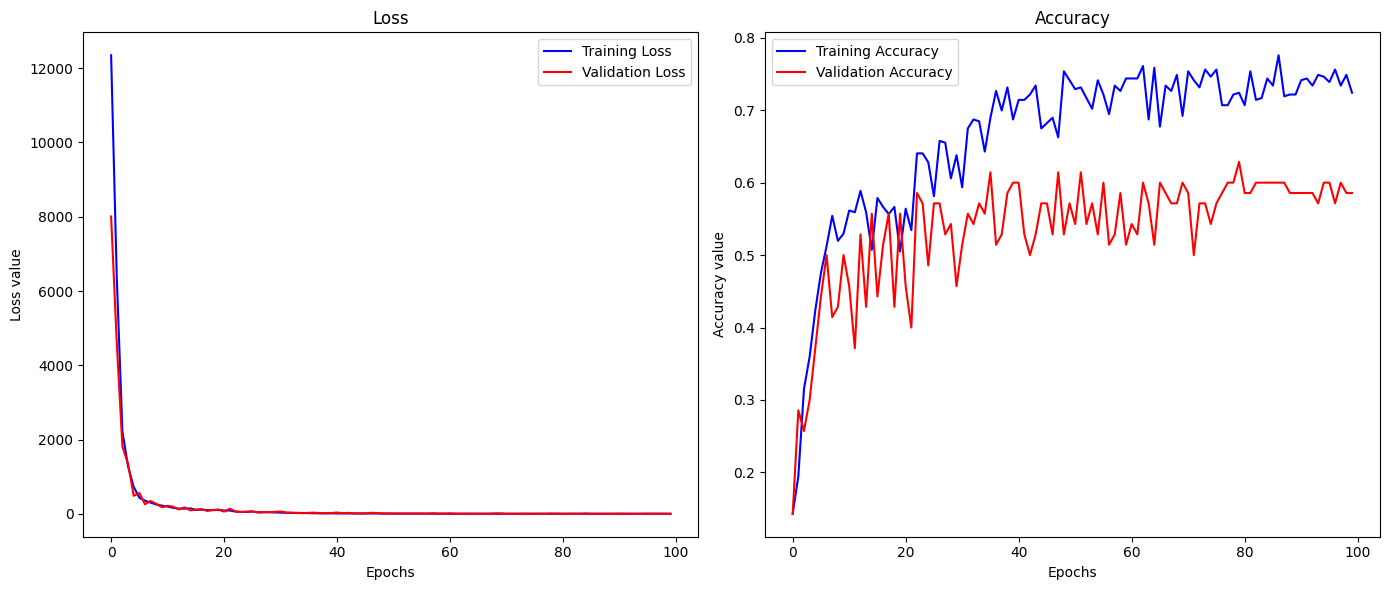

In [5]:
path_training_metrics = actual_dir + '/training_metrics.json'
path_validation_metrics = actual_dir+ '/validation_metrics.json'

# load the dictionary {'model': [model_name], 'epoch': [1, 2 ...], 'loss': [1.9, 1.8 ...], 'accuracy': [0.6, 0.7, ...], 'recall': [0.2, 0.3, ...], 'precision': [0.3, 0.4, ...], 'f1-score': [0.5, 0.6, ...]}
data_training = utils.load_metrics(path_training_metrics)
data_validation = utils.load_metrics(path_validation_metrics)

# Load the epochs, loss and accuracy in training and validation for the plots
epochs = data_training['epoch']
training_loss = data_training['loss']
training_accuracy = data_training['accuracy']

validation_loss = data_validation['loss']
validation_accuracy = data_validation['accuracy']

# Plot section
# 1st Subplot => Loss in Training and Validation
# 2nd Subplot => Accuracy in Training and Validation
utils.plot_loss_acc(epochs, training_loss, validation_loss, training_accuracy, validation_accuracy)

# Confusion Matrix

Plots and saves the confusion matrix for the test set, showing how the samples are classified compared to their true label

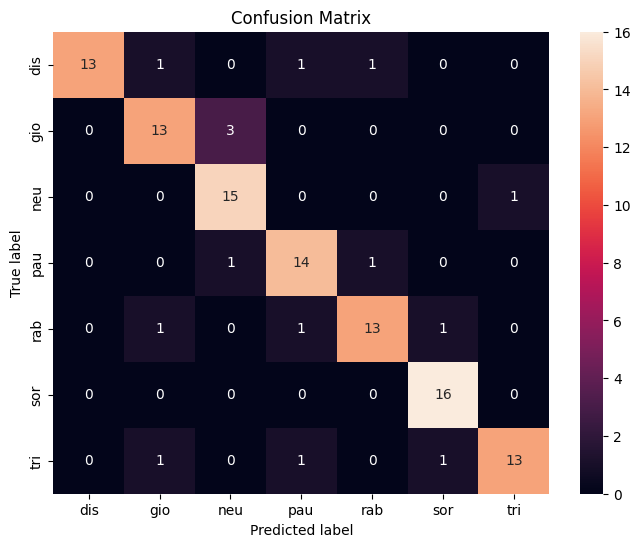

In [6]:
# Plot the confusion Matrix
class_names = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
utils.plot_confusion_matrix(cm, class_names, cmap='rocket')